In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
semap = fits.open(get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F160W/Threshold=Low(Segmap-generation_Morpheus)/F105W_segmap.fits'))
img = fits.open("/data/jip/2nd_TASK/run_SMACS_forcepho_JWST.ver.Img/img/f115w_JWST.fits")


# JWST Img --> Forcpho 맞춤형 수정

In [3]:
from astropy.io import fits
activate = fits.open('/data/jip/2nd_TASK/run_SMACS_forcepho/img/sersic1.6_rhalf0.080_snr100_noise0_data.fits')
file = fits.open('/data/jip/JWST_CEERS_EGS(2022.06.21)/JWST/jw01345-o002_t022_nircam_clear-f115w/jw01345-o002_t022_nircam_clear-f115w_i2d.fits')


hdu2 = fits.BinTableHDU.from_columns(
    [
    fits.Column(name='id', format='J', array=[0]),
    fits.Column(name='source_index', format='J', array=[0]),
    fits.Column(name='is_active', format='J', array=[0]),
    fits.Column(name='is_valid', format='J', array=[0]),
    fits.Column(name='n_iter', format='J', array=[0]),
    fits.Column(name='n_patch', format='J', array=[0]),
    fits.Column(name='roi', format='E', array=[0]),
    fits.Column(name='ra', format='D', array=[file[0].header['TARG_RA']]),
    fits.Column(name='dec', format='D', array=[file[0].header['TARG_DEC']]),
    fits.Column(name='q', format='D', array=[0]),
    fits.Column(name='pa', format='D', array=[0]),
    fits.Column(name='sersic', format='D', array=[1.6]),
    fits.Column(name='rhalf', format='D', array=[0.08]),
    fits.Column(name='F115W', format='D', array=[1]),    
    ]) #F115W CLEAR means the header of BinTableHDU 즉, hdu[1].heaader['FILTERS']=CLEAR 일 때 'CLEAR'가 맞는 것 즉, 필터 이름이 들어가는게 맞는 것 같다. 

''' 
with fits.open('/data/jip/2nd_TASK/run_SMACS_forcepho_JWST.ver.Img/img/f150w_JWST.fits', mode='update') as hdu:
    # Change something in hdu.
    hdu[-1] = hdu2
    hdu[-1].header['FILTERS']="F150W" #원래 CLEAR / 이미지 참 값은 F105W이지만, 호환 위해서 변경시도
    hdu[0].header['FILTERS']="F150W" #원래 F105W 였는데 JWST 호환위해 바꿈 / sci_ext=1로 둠 sci_ext가 거기인 것 같아서 그래서 hdu[1]에 필터 정보 부여
    hdu.flush()
'''   


# 원래 Transpose 되어 있던 것 내가 해제 해봄 dnjsfo imT uncT noiseT
def write_fits_to(out, im, unc, hdr, bands=[], noise=None, scene=None):
    """Write a FITS image with multuple extensions for image and uncertainty
    """
    image = fits.PrimaryHDU((im).T, header=hdr)
    uncertainty = fits.ImageHDU(unc.T, header=hdr)
    hdus = [image, uncertainty]
    if noise is not None:
        hdus.append(fits.ImageHDU(noise.T, header=hdr))

    if scene is not None:
        catalog = fits.BinTableHDU(scene)
        catalog.header["FILTERS"] = ",".join(bands)
        hdus.append(catalog)

    print(f"Writing to {out}")
    hdul = fits.HDUList(hdus)
    hdul.writeto(out, overwrite=True)
    hdul.close()

write_fits_to(out='/data/jip/2nd_TASK/run_SMACS_forcepho_JWST.ver.Img/img/f115w_JWST.fits', im=file[1].data, unc=file[2].data, hdr=file[0].header, bands=["F115W"], noise=file[6].data, scene=hdu2.data)

Writing to /data/jip/2nd_TASK/run_SMACS_forcepho_JWST.ver.Img/img/f115w_JWST.fits


## Cut and Save Fits (맞춤형 이미지를 원하는 영역만 자름)


In [4]:
# Download an example FITS file, create a 2D cutout, and save it to a
# new FITS file, including the updated cutout WCS.
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.wcs import WCS
from astropy import units as u

def write_fits_to(out, im, unc, hdr, bands=[], noise=None, scene=None):
    """Write a FITS image with multuple extensions for image and uncertainty
    """
    image = fits.PrimaryHDU((im).T, header=hdr)
    uncertainty = fits.ImageHDU(unc.T, header=hdr)
    hdus = [image, uncertainty]
    if noise is not None:
        hdus.append(fits.ImageHDU(noise.T, header=hdr))

    if scene is not None:
        catalog = fits.BinTableHDU(scene)
        catalog.header["FILTERS"] = ",".join(bands)
        hdus.append(catalog)

    print(f"Writing to {out}")
    hdul = fits.HDUList(hdus)
    hdul.writeto(out, overwrite=True)
    hdul.close()


def download_image_save_cutout(filename, position, size, cutout_filename):   # (url, position, size)
    # 여러 fits를 잘라서 다같이 합쳐야함
    # Download the image
    # filename = download_file(url)
    # Load the image and the WCS
    hdu0 = fits.open(filename)[0]
    hdu1 = fits.open(filename)[1]
    hdu2 = fits.open(filename)[2]
    hdu3 = fits.open(filename)[3] #BinTable이라 안잘라도됨
    wcs = WCS(hdu0.header)

    # Make the cutout, including the WCS
    cutout0 = Cutout2D(hdu0.data, position=position, size=size, wcs=wcs)
    cutout1 = Cutout2D(hdu1.data, position=position, size=size, wcs=wcs)
    cutout2 = Cutout2D(hdu2.data, position=position, size=size, wcs=wcs)

    # Put the cutout image in the FITS HDU
    hdu0.data = cutout0.data
    hdu1.data = cutout1.data
    hdu2.data = cutout2.data

    # Update the FITS header with the cutout WCS
    hdu0.header.update(cutout0.wcs.to_header())
    hdu1.header.update(cutout1.wcs.to_header())
    hdu2.header.update(cutout2.wcs.to_header())

    #CRPIX 수정? 
    hdu0.header["CRPIX1"] += cutoutposition[0]
    hdu0.header["CRPIX2"] += cutoutposition[1]
    hdu0.header["CRVAL1"] = hdu3.data['ra'][0]
    hdu0.header["CRVAL2"] = hdu3.data['dec'][0]
    hdu0.header['CTYPE1'] = "RA---TAN"
    hdu0.header['CTYPE2'] = "DEC--TAN"


    # Write the cutout to a new FITS file
    # cutout_filename = 'img/f105w_cutout.fits'
    # hdu0.writeto(cutout_filename, overwrite=True)
    return hdu0, hdu1, hdu2, hdu3

cutoutposition = (1690, 1882)
cutoutsize = (64, 64)

# if __name__ == '__main__':
filename = ['/data/jip/2nd_TASK/run_SMACS_forcepho_JWST.ver.Img/img/f115w_JWST.fits']
savepath = ['img/f115w_JWST_cutout.fits']
cutimglist = []
for i in range(np.size(filename)):
    im, unc, noise, scene = download_image_save_cutout(filename[i], cutoutposition, cutoutsize, savepath[i])
    write_fits_to(out=savepath[i], im=im.data, unc=unc.data, hdr=im.header, bands=["F115W"], noise=noise.data, scene=scene.data)



Writing to img/f115w_JWST_cutout.fits


Set MJD-BEG to 59751.956607 from DATE-BEG.
Set MJD-END to 59752.051797 from DATE-END'. [astropy.wcs.wcs]


In [5]:
cut = fits.open('/data/jip/2nd_TASK/run_SMACS_forcepho_JWST.ver.Img/img/f115w_JWST_cutout.fits')
activate = fits.open('/data/jip/2nd_TASK/run_SMACS_forcepho/img/sersic1.6_rhalf0.080_snr100_noise0_data.fits')


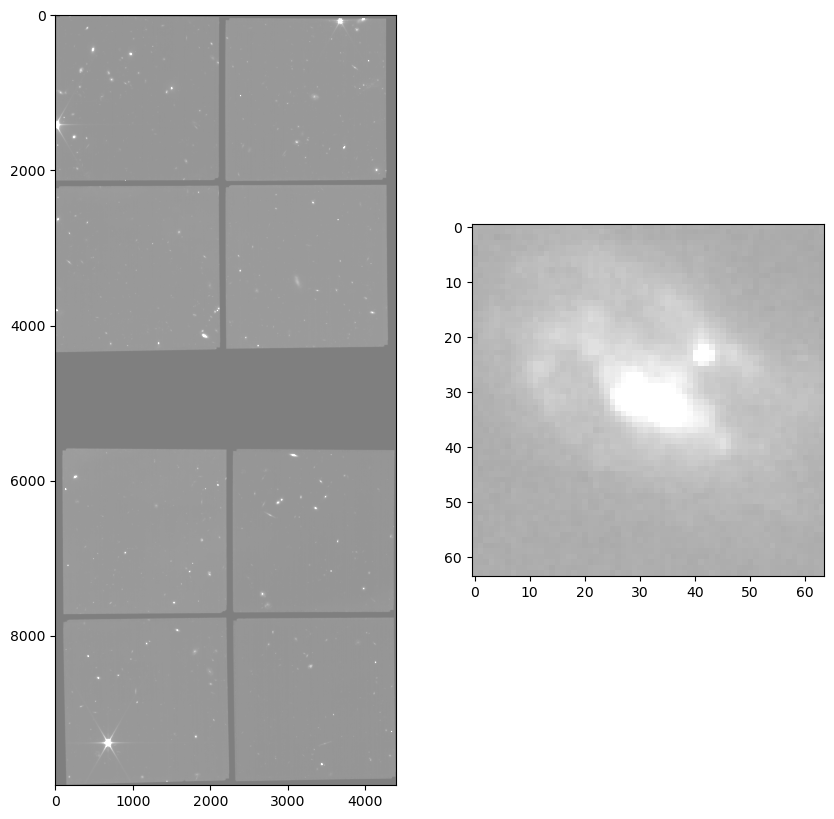

In [6]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axes[0].imshow(fits.open('/data/jip/2nd_TASK/run_SMACS_forcepho_JWST.ver.Img/img/f115w_JWST.fits')[0].data, cmap='gray', vmin=-1, vmax=1)
axes[1].imshow(fits.open('/data/jip/2nd_TASK/run_SMACS_forcepho_JWST.ver.Img/img/f115w_JWST_cutout.fits')[0].data, cmap='gray', vmin=-0.5, vmax=0.5)


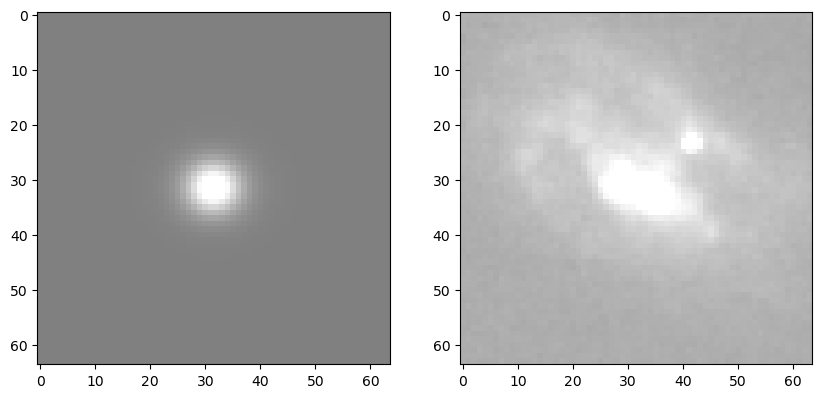

In [7]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axes[0].imshow(activate[0].data, cmap='gray', vmin=-0.01, vmax=0.01)
axes[1].imshow(fits.open('/data/jip/2nd_TASK/run_SMACS_forcepho_JWST.ver.Img/img/f115w_JWST_cutout.fits')[0].data, cmap='gray', vmin=-0.5, vmax=0.5)


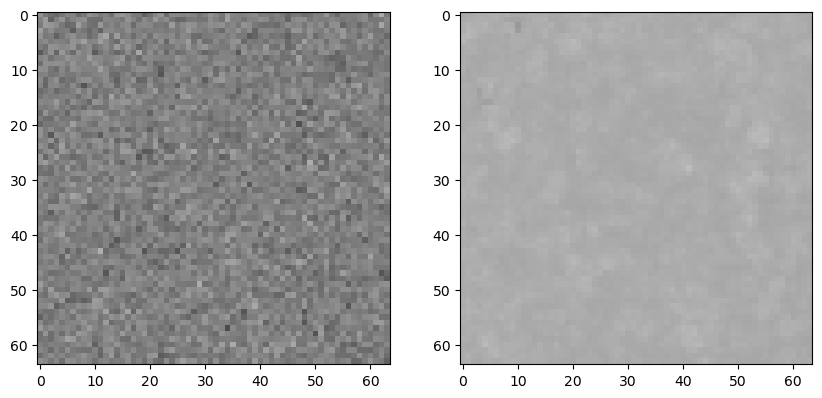

In [8]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axes[0].imshow(activate[2].data, cmap='gray', vmin=-0.01, vmax=0.01)
axes[1].imshow(fits.open('/data/jip/2nd_TASK/run_SMACS_forcepho_JWST.ver.Img/img/f115w_JWST_cutout.fits')[2].data, cmap='gray', vmin=-8e-05, vmax=8e-05)


In [9]:
activate[0].header['FILTER']

'CLEAR'

In [10]:
activate[-1].header['FILTERS'] # 맨 마지막 이미지 자르기해서 넣는 셀과 관련있음 거기 bands=를 바꾸면 바뀜  write_fits_to(out=savepath[i], im=im.data, unc=unc.data, hdr=im.header, bands=["CLEAR"], noise=noise.data, scene=scene.data) 

'CLEAR'

In [11]:
cut[-1].data

FITS_rec([(0, 0, 0, 0, 0, 0, 0., 215.072595, 52.98783056, 0., 0., 1.6, 0.08, 1.)],
         dtype=(numpy.record, [('id', '>i4'), ('source_index', '>i4'), ('is_active', '>i4'), ('is_valid', '>i4'), ('n_iter', '>i4'), ('n_patch', '>i4'), ('roi', '>f4'), ('ra', '>f8'), ('dec', '>f8'), ('q', '>f8'), ('pa', '>f8'), ('sersic', '>f8'), ('rhalf', '>f8'), ('F115W', '>f8')]))

In [12]:
cut[-1].header['FILTERS']

'F115W'

In [13]:
import astropy 
from astropy.wcs import WCS
print(WCS(astropy.io.fits.getheader('/data/jip/2nd_TASK/run_SMACS_forcepho_JWST.ver.Img/img/f115w_JWST_cutout.fits')))
print(WCS(astropy.io.fits.getheader('/data/jip/2nd_TASK/run_SMACS_forcepho/img/sersic1.6_rhalf0.080_snr100_noise0_data.fits')))

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 215.072595  52.98783055555555  
CRPIX : 32.0  32.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 64  64
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.0  -27.0  
CRPIX : 32.5  32.5  
PC1_1 PC1_2  : 8.3333333333333e-06  0.0  
PC2_1 PC2_2  : 0.0  8.3333333333333e-06  
CDELT : 1.0  1.0  
NAXIS : 64  64


In [259]:
''' f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band in zip(axes, cutimglist, ['F115W', 'F115W cut', 'F140W', 'F160W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.1)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show() ''' 

" f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))\naxes = np.array(axes).flatten()\n\nfor ax, arr, band in zip(axes, cutimglist, ['F115W', 'F115W cut', 'F140W', 'F160W']):\n    ax.set_title(f'{band} Image', fontsize=21)\n    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.1)\n    ax.set_xlabel('x', fontsize=21)\n    ax.set_ylabel('y', fontsize=21)\n    ax.tick_params(axis='x', labelsize=21)\n    ax.tick_params(axis='y', labelsize=21)\n\nplt.tight_layout()\nplt.show() "

In [260]:
from astropy.table import Table
activate_psf = Table.read("/data/jip/2nd_TASK/run_forcepho/tests/sersic1.6_rhalf0.080_snr100_noise0/sersic1.6_rhalf0.080_snr100_noise0_psf.h5")
